In [1]:
import numpy as np
import scipy
import time
from matplotlib import pyplot as plt

side = 1000
image = np.zeros([side,side])
speckleSize = 100
xPhasors = int(np.round(side/speckleSize))
yPhasors = int(np.round(side/speckleSize))
phasor = np.zeros([side,side],dtype = complex)

noiseSize = 2

def poissonNoise(noiseSize,side):
    poisson = np.random.poisson(noiseSize,size=[side,side]) 
    poisson = poisson/np.max(poisson)
    return poisson

for i in range(xPhasors):
    for j in range(yPhasors):
        phase = np.random.random()*2*np.pi*1j
        phasor[i,j] = np.exp(phase)


speckle = np.fft.fft2(phasor)
speckle = [np.abs(elt)**2 for elt in speckle]
speckle /= np.max(speckle)

poisson = poissonNoise(noiseSize,side)
#speckle += poisson

#Add 2 uncorrelated patterns together to get 0.5 contrast
#Simulate charge cloud: we need better resolution than the detector size
# do for example 1000x1000 and then finally get 200x200 when I digitize.
# Speckle size should also be bigger than the 5x5 detector size.

plt.figure(figsize=[10,10])
plt.imshow(speckle)

In [20]:
#https://math.stackexchange.com/questions/316175/probability-to-choose-specific-item-in-a-weighted-sampling-without-replacement#320640
from ast import literal_eval as make_tuple
from scipy import ndimage

def makePhotons(nPhotons):
    speckleLabels = [["({},{})".format(j,i) for i in range(np.shape(speckle)[0])] for j in range(np.shape(speckle)[1])]
    speckleLabels = [elt for row in speckleLabels for elt in row] # Flatten
    flatSpeckle = np.reshape(speckle,np.shape(speckle)[0]*np.shape(speckle)[1]) # Flatten
    flatSpeckle /= np.sum(flatSpeckle) # Normalize
    choices = np.random.choice(speckleLabels,nPhotons, p=flatSpeckle)

    photons = np.zeros(np.shape(speckle))
    for elt in choices:
        tup = make_tuple(elt)
        photons[tup[0],tup[1]] = 1 # Or assign some number to phton to electron-photon conversion. So use 
    
    return photons

# 1 photon 8keV gives 3.6eV/electron (say 2000), add losses later
photons = makePhotons(100)
Eelectron = np.floor(8000/3.6/13) #3.6 eV per electron, 13 electron per ADU
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,10)

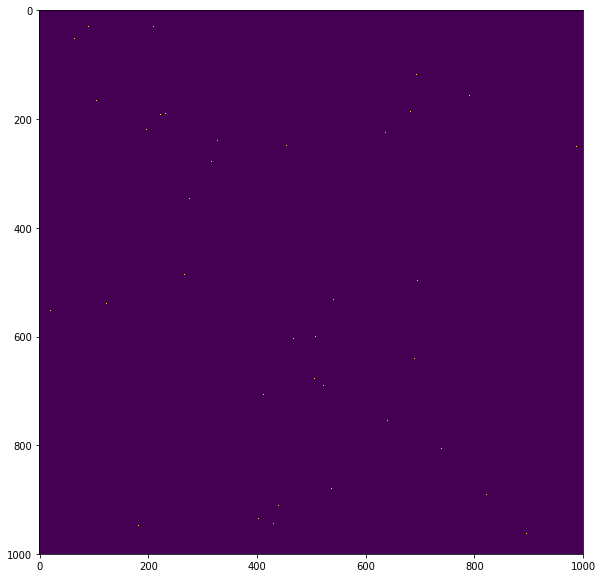

In [21]:
plt.figure(figsize=[10,10])
plt.imshow(photons)

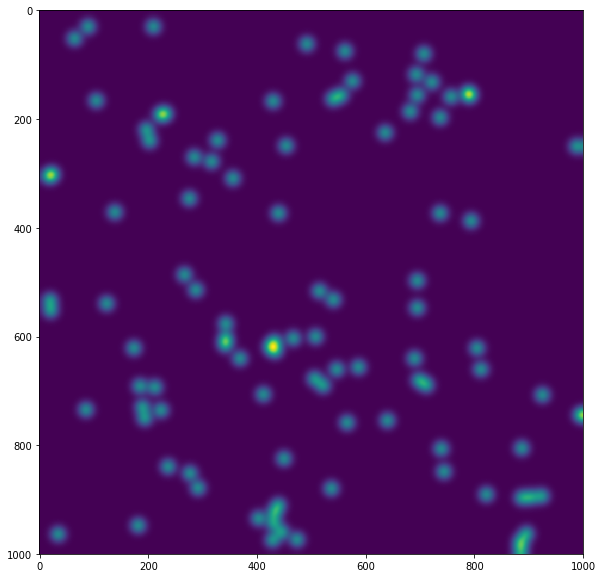

In [22]:
plt.figure(figsize=[10,10])
plt.imshow(electrons)

In [24]:
# Charge map
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)

charge = rebin(electrons,(100,100))

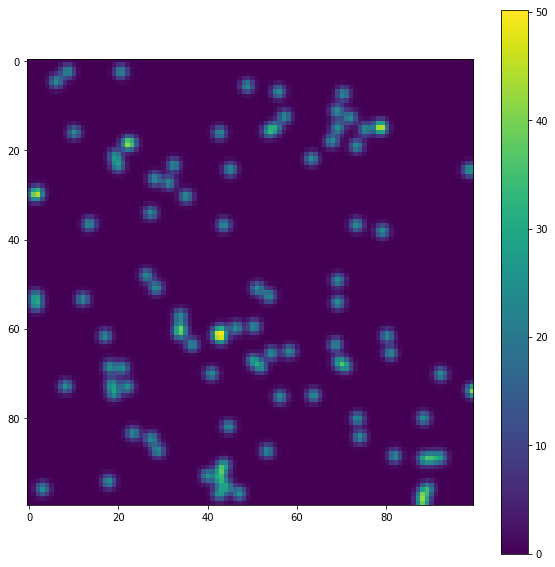

In [28]:
plt.figure(figsize=[10,10])
plt.imshow(charge)
plt.colorbar()

In [29]:
def dropletSignal(charge):
    ADUThresh = Eelectron*0.001
    labeled, nr_objects = ndimage.label(charge > ADUThresh)
    dropletSignal = np.zeros(nr_objects+1)
    for i in range(1,nr_objects+1):
        mask = labeled == i
        dropletSignal[i] = np.sum(np.multiply(mask,charge))

    minSignal = 0.5
    dropletSignal = np.multiply(dropletSignal,dropletSignal > minSignal)
    nonzeroSignal = [elt for elt in dropletSignal if elt != 0]
    
    return nonzeroSignal

In [148]:
import time

start = time.time()
histograms = []
gaussianSize = 1
photonEnergy = 8000;
NElectrons = photonEnergy/3.6;
AduPerElectron = 13;
readoutNoise = 4;
numberPhotons = 200
iterations = 20

for i in range(iterations):
    #gaussianSize = i
    photons = makePhotons(numberPhotons)#*i)
    electrons = ndimage.filters.gaussian_filter(photons*NElectrons,gaussianSize)
    charge = rebin(np.round(electrons)/AduPerElectron,(100,100))
    normal = np.random.normal(loc=0, scale=readoutNoise, size = np.shape(charge)) # adding readout noise
    charge += normal
    bins = np.linspace(-20,300,51)
    hist = np.histogram(charge.flatten(),bins = bins);
    histograms.append(hist)
end = time.time()

end-start

12.654671907424927

In [154]:
histograms[0]

(array([   2,  364, 3718, 4796,  803,   31,    3,    4,   12,   11,   32,
          25,    4,    0,    0,    4,    7,    1,    0,    2,   12,   24,
          22,    2,    0,    0,    5,   10,   29,   50,   17,    3,    0,
           0,    0,    0,    0,    1,    1,    0,    0,    0,    0,    0,
           0,    0,    1,    2,    1,    0]),
 array([-20. , -13.6,  -7.2,  -0.8,   5.6,  12. ,  18.4,  24.8,  31.2,
         37.6,  44. ,  50.4,  56.8,  63.2,  69.6,  76. ,  82.4,  88.8,
         95.2, 101.6, 108. , 114.4, 120.8, 127.2, 133.6, 140. , 146.4,
        152.8, 159.2, 165.6, 172. , 178.4, 184.8, 191.2, 197.6, 204. ,
        210.4, 216.8, 223.2, 229.6, 236. , 242.4, 248.8, 255.2, 261.6,
        268. , 274.4, 280.8, 287.2, 293.6, 300. ]))

In [168]:
import h5py
h = h5py.File('test1.hdf5','w')

def namer(numberPhotons,gaussianSize,readoutNoise,AduPerElectron,photonEnergy,NElectrons,iterations,i):
    return "p" + str(numberPhotons) + "g" + str(gaussianSize) + "rn" + str(readoutNoise) + "adu" + str(AduPerElectron) + "E"+ str(photonEnergy) + "ne" + str(NElectrons) + "it" + str(iterations) + "i" + str(i) 

In [167]:
h.close()

In [164]:
for i in range(iterations):
    datasetName = namer(numberPhotons,gaussianSize,readoutNoise,AduPerElectron,photonEnergy,NElectrons,iterations,i)
    if(i == 0): 
        datasetNameAxis = datasetName[:-1]+"Xaxis"
        h.create_dataset(datasetNameAxis, data = histograms[0][1])
    h.create_dataset(datasetName, data = histograms[i][0])

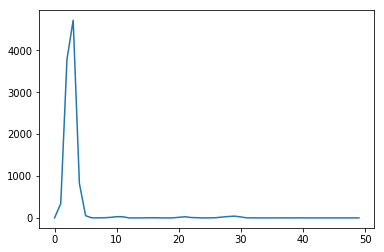

In [166]:
dataN = namer(numberPhotons,gaussianSize,readoutNoise,AduPerElectron,photonEnergy,NElectrons,iterations,10)
plt.plot(h[dataN])

In [170]:
# This routine puts together much of the work to be able to let it run for long batches

def run(numberPhotons,gaussianSize,readoutNoise,AduPerElectron,photonEnergy,NElectrons,iterations):
    start = time.time()
    histograms = []

    for i in range(iterations):
        photons = makePhotons(numberPhotons)
        electrons = ndimage.filters.gaussian_filter(photons*NElectrons,gaussianSize)
        charge = rebin(np.round(electrons)/AduPerElectron,(100,100))
        normal = np.random.normal(loc=0, scale=readoutNoise, size = np.shape(charge)) # adding readout noise
        charge += normal
        bins = np.linspace(-20,300,51)
        hist = np.histogram(charge.flatten(),bins = bins);
        histograms.append(hist)
    end = time.time()
    
    return histograms,end-start

In [171]:
numberPhotonsBATCH = [50,100,300,600,1000,2000]
gaussianSizeBATCH = [0,1,5,10,20,50]

for numberPhotons in numberPhotonsBATCH:
    for gaussianSize in gaussianSizeBATCH:
        histograms, _ = run(numberPhotons,gaussianSize,readoutNoise,AduPerElectron,photonEnergy,NElectrons,iterations)
        
        for i in range(iterations):
            datasetName = namer(numberPhotons,gaussianSize,readoutNoise,AduPerElectron,photonEnergy,NElectrons,iterations,i)
            if(i == 0): 
                datasetNameAxis = datasetName[:-1]+"Xaxis"
                h.create_dataset(datasetNameAxis, data = histograms[0][1])
            h.create_dataset(datasetName, data = histograms[i][0])

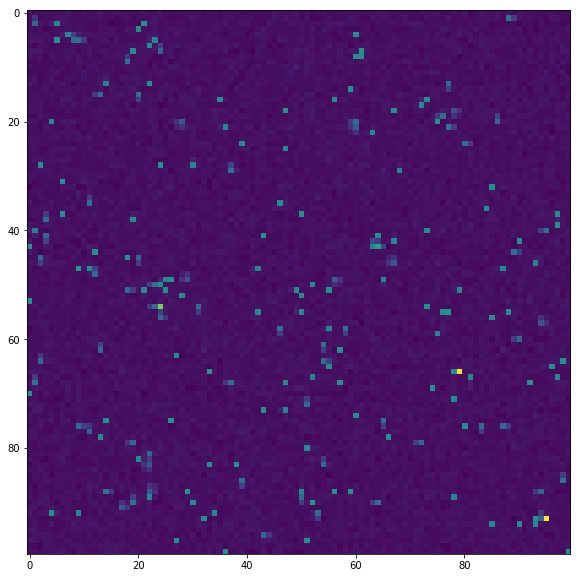

In [57]:
plt.figure(figsize=[10,10]);plt.clf;
plt.imshow(charge)

In [ ]:
# make the algorithm faster
# use the windows computers
# learn how to save it into an hdf5 file, determine a format


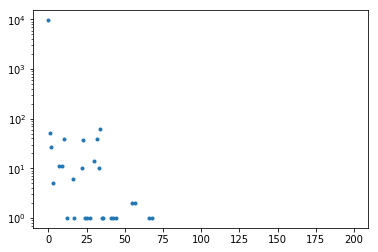

In [42]:
np.shape(histograms[1][1])
plt.figure();
plt.semilogy(histograms[1][0],'.')

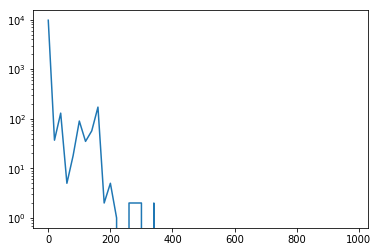

In [58]:
totalHist = [hist[0] for hist in histograms]
totalHist = np.sum(totalHist, axis = 0)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(bins[:-1],totalHist,'-')
ax.set_yscale('log')

In [ ]:
# Histogram in terms of the Gaussian size
photons = makePhotons(100)
plt.figure(figsize = [20,20])


# Gaussian = 0
plt.subplot(3,2,1)
gaussianSize = 0
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,gaussianSize)
charge = rebin(electrons,(100,100))
#signal = dropletSignal(charge)
fontsize = 15
plt.title("Gaussian = {}".format(gaussianSize), fontsize = fontsize)
plt.xlabel("Energy (eV)", fontsize = fontsize)
plt.hist(charge.flatten(),100);

# Gaussian = 1
plt.subplot(3,2,2)
gaussianSize = 1
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,gaussianSize)
charge = rebin(electrons,(100,100))
#signal = dropletSignal(charge)
fontsize = 15
plt.title("Gaussian = {}".format(gaussianSize), fontsize = fontsize)
plt.xlabel("Energy (eV)", fontsize = fontsize)
plt.hist(charge.flatten(),100);

# Gaussian = 2
plt.subplot(3,2,3)
gaussianSize = 2
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,gaussianSize)
charge = rebin(electrons,(100,100))
#signal = dropletSignal(charge)
fontsize = 15
plt.title("Gaussian = {}".format(gaussianSize), fontsize = fontsize)
plt.xlabel("Energy (eV)", fontsize = fontsize)
plt.hist(charge.flatten(),100);

# Gaussian = 5
plt.subplot(3,2,4)
gaussianSize = 5
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,gaussianSize)
charge = rebin(electrons,(100,100))
#signal = dropletSignal(charge)
fontsize = 15
plt.title("Gaussian = {}".format(gaussianSize), fontsize = fontsize)
plt.xlabel("Energy (eV)", fontsize = fontsize)
plt.hist(charge.flatten(),100);

# Gaussian = 10
plt.subplot(3,2,5)
gaussianSize = 10
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,gaussianSize)
charge = rebin(electrons,(100,100))
#signal = dropletSignal(charge)
fontsize = 15
plt.title("Gaussian = {}".format(gaussianSize), fontsize = fontsize)
plt.xlabel("Energy (eV)", fontsize = fontsize)
plt.hist(charge.flatten(),100);


In [ ]:
# Add Gaussian noise
# Is there a way to calibrate each pixel in the detector to find the peak and std for each pixel?

photons = makePhotons(100)

gaussianSize = 5
electrons = ndimage.filters.gaussian_filter(photons * Eelectron,gaussianSize)
charge = downsize(electrons,0.1)

peak = np.max(charge)*0.05 #eV
std = 1
normal = np.random.normal(loc = 0, scale = std, size = np.shape(charge)) # Readout noise
charge += peak*normal
signal = dropletSignal(charge)

plt.figure(figsize = [20,10])
plt.subplot(1,2,1)
plt.title("Gaussian = {}".format(gaussianSize), fontsize = 15)
plt.xlabel("Energy (eV)", fontsize = 15)
plt.hist(signal,100)

plt.subplot(1,2,2)
plt.title("Charge with a peak Gaussian noise of {} eV".format(round(peak*100)/100), fontsize = 15)
plt.imshow(charge)
plt.colorbar();

In [ ]:
plt.imshow(charge)

In [ ]:
plt.hist(nonzeroSignal,100);

In [ ]:
dropletSignal[0]

In [ ]:
# Plot hist of above as function of Gaussian size
# Add Gaussian readout noise, about 5-10/pixel (play)

In [ ]:
# sum of pixels for 1 photon should be around 200

# Add Gaussian noise to each pixel, sigma \pm 3



lam = 0.1
poisson = poissonNoise(lam,np.shape(charge)[0])/np.max(poisson)
NSR = 0.5 
peak = np.max(charge)*NSR
charge += poisson*peak

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(charge)

In [ ]:
# Droplet algorithm
charge -= np.mean(charge)
ADUThresh = 0
labeled, nr_objects = ndimage.label(charge > ADUThresh)

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(labeled == 0)

In [ ]:
dropletSignal = np.zeros(nr_objects+1)
for i in range(0,nr_objects+1):
    mask = labeled == i
    dropletSignal[i] = np.sum(np.multiply(mask,charge))

minSignal = 0.5
dropletSignal = np.multiply(dropletSignal,dropletSignal > minSignal)
nonzeros = [elt for elt in dropletSignal if elt != 0]
plt.hist(nonzeros,20);

In [ ]:
plt.hist(dropletSignal,20);

In [ ]:
plt.plot(dropletSignal,'.')

In [ ]:
plt.hist(nonzeros,20);

In [ ]:
# Repeat 100 times to collect more photons, same side size
# Do the histogram also before the Gaussian, you will see the graph but with just straight lines up

In [ ]:
# Photon map
# Poisson distribution with the probabilities given by the speckle
# https://arxiv.org/pdf/1309.1287.pdf
# Following: https://hpaulkeeler.com/simulating-an-inhomogeneous-poisson-point-process/
nPhotons = 100
lambd = speckle
Lambd = np.sum(lambd)
lambd /= Lambd

sampling = np.random.poisson(lam = speckle2, size = np.shape(speckle2))
plt.imshow(sampling)

In [ ]:

import numpy as np; #NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt #For plotting
from scipy.optimize import minimize #For optimizing
from scipy import integrate #For integrating

#Simulation window parameters
xMin=0;xMax=np.shape(speckle)[0];
yMin=0;yMax=np.shape(speckle)[1];
xDelta=xMax-xMin;yDelta=yMax-yMin; #rectangle dimensions
areaTotal=xDelta*yDelta;

numbSim=10**3;  #number of simulations

s=0.5; #scale parameter

#Point process parameters
def fun_lambda(x,y):
    print(x,y)
    return speckle[x,y]#100*np.exp(-(x**2+y**2)/s**2); #intensity function

###START -- find maximum lambda -- START ###
#For an intensity function lambda, given by function fun_lambda, 
#finds the maximum of lambda in a rectangular region given by 
#[xMin,xMax,yMin,yMax].    
def fun_Neg(x):
    return -fun_lambda(x[0],x[1]); #negative of lambda 
    
xy0=[(xMin+xMax)/2,(yMin+yMax)/2];#initial value(ie centre)
#Find largest lambda value
#resultsOpt=minimize(fun_Neg,xy0,bounds=((xMin, xMax), (yMin, yMax)));
#lambdaNegMin=resultsOpt.fun; #retrieve minimum value found by minimize
#lambdaMax=-lambdaNegMin; 
lambdaMax = np.max(speckle)
###END -- find maximum lambda -- END ###

#define thinning probability function
def fun_p(x,y):
    return fun_lambda(x,y)/lambdaMax;    

#for collecting statistics -- set numbSim=1 for one simulation
numbPointsRetained=np.zeros(numbSim); #vector to record number of points
for ii in range(numbSim):
    #Simulate a Poisson point process
    numbPoints = nPhotons#np.random.poisson(areaTotal*lambdaMax);#Poisson number of points
    xx = np.random.uniform(0,xDelta,((numbPoints ,1)))+xMin;#x coordinates of Poisson points
    yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin;#y coordinates of Poisson points
    
    #calculate spatially-dependent thinning probabilities
    p=fun_p(xx,yy); 
    
    #Generate Bernoulli variables (ie coin flips) for thinning
    booleRetained=np.random.uniform(0,1,((numbPoints,1)))<p; #points to be retained
    
    #x/y locations of retained points
    xxRetained=xx[booleRetained]; yyRetained=yy[booleRetained];
    numbPointsRetained[ii]=xxRetained.size;

#Plotting
plt.scatter(xxRetained,yyRetained, edgecolor='b', facecolor='none', alpha=0.5 );
plt.xlabel("x"); plt.ylabel("y");
plt.show(); 

#run empirical test on number of points generated
if numbSim>=10:
        #total mean measure (average number of points)
        LambdaNumerical=integrate.dblquad(fun_lambda,xMin,xMax,lambda x: yMin,lambda y: yMax)[0];
        #Test: as numbSim increases, numbPointsMean converges to LambdaNumerical
        numbPointsMean=np.mean(numbPointsRetained);
        #Test: as numbSim increases, numbPointsVar converges to LambdaNumerical
        numbPointsVar=np.var(numbPointsRetained);  

In [ ]:
import numpy as np; #NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt #For plotting
from scipy.optimize import minimize #For optimizing
from scipy import integrate
 
#Simulation window parameters
xMin=-1;xMax=1;
yMin=-1;yMax=1;
xDelta=xMax-xMin;yDelta=yMax-yMin; #rectangle dimensions
areaTotal=xDelta*yDelta;
 
s=0.5; #scale parameter
 
#Point process parameters
def fun_lambda(x,y):
    return 100*np.exp(-(x**2+y**2)/s**2); #intensity function
 
###START -- find maximum lambda -- START ###
#For an intensity function lambda, given by function fun_lambda,
#finds the maximum of lambda in a rectangular region given by
#[xMin,xMax,yMin,yMax].
def fun_Neg(x):
    return -fun_lambda(x[0],x[1]); #negative of lambda
 
xy0=[(xMin+xMax)/2,(yMin+yMax)/2];#initial value(ie centre)
#Find largest lambda value
resultsOpt=minimize(fun_Neg,xy0,bounds=((xMin, xMax), (yMin, yMax)));
lambdaNegMin=resultsOpt.fun; #retrieve minimum value found by minimize
lambdaMax=-lambdaNegMin;
###END -- find maximum lambda -- END ###
 
#define thinning probability function
def fun_p(x,y):
    return fun_lambda(x,y)/lambdaMax;
 
#Simulate a Poisson point process
numbPoints = np.random.poisson(lambdaMax*areaTotal);#Poisson number of points
xx = np.random.uniform(0,xDelta,((numbPoints,1)))+xMin;#x coordinates of Poisson points
yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin;#y coordinates of Poisson points
 
#calculate spatially-dependent thinning probabilities
p=fun_p(xx,yy);
 
#Generate Bernoulli variables (ie coin flips) for thinning
booleRetained=np.random.uniform(0,1,((numbPoints,1)))<p; #points to be thinned
 
#x/y locations of retained points
xxRetained=xx[booleRetained]; yyRetained=yy[booleRetained];
 
#Plotting
plt.scatter(xxRetained,yyRetained, edgecolor='b', facecolor='none', alpha=0.5 );
plt.xlabel("x"); plt.ylabel("y");
plt.show();